Since by now you have all written some Python code that works, we are going to jump directly into doing some science tasks with data pulled directly from real sources, instead of using a dataset we cleaned for you.

Some of the stuff we are going to do will be fairly advanced but I think that seeing how the language can automate your workflow - and especially how it can handle the tasks that are annoying or difficult - will make it more likely that you'll come back to it. We are throwing a lot at you, so put a red sticky up if you need hands-on help and interrupt if you have a question, and we'll adjust as we go.

We are interested in the comparing the discharge over a specific time period at different points along the Colorado River. The traditional way to do this is through the USGS website:

http://waterwatch.usgs.gov/?m=real&r=az

and then precisely selecting the station you want and going through the whole process by hand. At the end, you have end up with some csv files that look like this:

http://waterdata.usgs.gov/az/nwis/uv?cb_00060=on&cb_00065=on&format=rdb&site_no=09380000&period=&begin_date=2016-01-01&end_date=2016-01-10

The header is annoying because it doesn't always have the same number of lines. Depending on the specific options we selected, the table has a different number of columns. Automating the analysis of these files is rough, and it requires quite a bit of handholding in Excel. If we were to do this frequently or for many stations, the chances of introducing an error are high.

Instead of doing this by hand, we are going to automate the entire process of data import and processing using Python. We will write a script that will take two dates and a list of stations and will automatically create plots of the gage height and discharge for each of those stations.

Earlier today we used a Python library called numpy to handle arrays of data. `numpy arrays` are matrices and are great for doing calculations on data, but they can only contain floats or integers. Tabular data are best handled by spreadsheets where entries such as dates and times are in some useful format.

One of the best options for working with tabular data in Python is the Python Data Analysis Library (a.k.a. Pandas). The Pandas library provides data structures, produces high quality plots with matplotlib (the plotting library we used earlier) and integrates nicely with other libraries that can use numpy arrays.

Let's start by importing streamgage data from a file that has already been partially cleaned up. Open the file in a text editor and see: we removed the header and the column format line ("5d 15s..."), and saved it as a comma-delimited file instead of tab delimited.

We will first import the Pandas library and give it the shortcut `pd` and use the Pandas function `read_csv` to import the file. This will pull the contents of the file into a DataFrame. Let's assign it to a variable named `data` (so original!) and print the first 5 lines:

In [22]:
import pandas as pd

data = pd.read_csv('data/streamgage.csv')
data.head()

,agency_cd,site_no,datetime,tz_cd,01_00060,01_00060_cd,02_00065,02_00065_cd
0,USGS,9163500,1/1/16 0:00,MST,3510,P,3.78,P
1,USGS,9163500,1/1/16 0:15,MST,3510,P,3.78,P
2,USGS,9163500,1/1/16 0:30,MST,3490,P,3.77,P
3,USGS,9163500,1/1/16 0:45,MST,3490,P,3.77,P
4,USGS,9163500,1/1/16 1:00,MST,3470,P,3.76,P


## What's a DataFrame? {.callout}

A DataFrame is a 2-dimensional data structure that can store data of different types (including characters, integers, floating point values, factors and more) in columns. It is similar to a spreadsheet or an SQL table or the data.frame in R.

Check the data type of `data` using the `type` method. The `type` method and `__class__` attribute tell us what type of object the variable points to. We will not discuss the full meaning of this terminology, related to object-oriented programming, in the workshop.

In [23]:
print type(data)
print data.__class__

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


Each column in a DataFrame also has a type. We can use `data.dtypes` to view the data type for each column. `int64` represents numeric integer values - `int64` cells can not store decimals. `object` represents strings (letters and numbers). `float64` represents numbers with decimals.

In [24]:
data.dtypes

agency_cd       object
site_no          int64
datetime        object
tz_cd           object
01_00060         int64
01_00060_cd     object
02_00065       float64
02_00065_cd     object
dtype: object

We need to give the DataFrame column names that are easier to read. Let's create a list with the column names we want:

In [25]:
new_column_names = ['Agency', 'Station', 'OldDateTime', 'Timezone', 'Discharge_cfs', 'Discharge_stat', 'Stage_ft', 'Stage_stat']

We can see the column names of a DataFrame using the method `columns`, and we can use that same method to assign it the new column names:

In [26]:
print 'Old column names:', data.columns

data.columns = new_column_names

print 'New column names:', data.columns

Old column names: Index([u'agency_cd', u'site_no', u'datetime', u'tz_cd', u'01_00060',
       u'01_00060_cd', u'02_00065', u'02_00065_cd'],
      dtype='object')
New column names: Index([u'Agency', u'Station', u'OldDateTime', u'Timezone', u'Discharge_cfs',
       u'Discharge_stat', u'Stage_ft', u'Stage_stat'],
      dtype='object')


In [27]:
data.head()

,Agency,Station,OldDateTime,Timezone,Discharge_cfs,Discharge_stat,Stage_ft,Stage_stat
0,USGS,9163500,1/1/16 0:00,MST,3510,P,3.78,P
1,USGS,9163500,1/1/16 0:15,MST,3510,P,3.78,P
2,USGS,9163500,1/1/16 0:30,MST,3490,P,3.77,P
3,USGS,9163500,1/1/16 0:45,MST,3490,P,3.77,P
4,USGS,9163500,1/1/16 1:00,MST,3470,P,3.76,P


The values in each column of a Pandas DataFrame can be accessed using the column name. If we want to access more than one column at once, we use a list of column names:

In [28]:
data[['Discharge_cfs','Stage_ft']].head()

,Discharge_cfs,Stage_ft
0,3510,3.78
1,3510,3.78
2,3490,3.77
3,3490,3.77
4,3470,3.76


We can also create new columns using this syntax:

In [29]:
data['Stage_m'] = data['Stage_ft'] * 0.3048
data['Stage_m'].head()

0    1.152144
1    1.152144
2    1.149096
3    1.149096
4    1.146048
Name: Stage_m, dtype: float64

## Fixing the station name

When Pandas imported the data, it read the station name as an integer and removed the initial zero. We can fix the station name by replacing the values of that column.

Remember that we are doing all of this so we can later automate the process for multiple stations. Instead of writing the corrected station name ourselves, let's build it from the values available in the DataFrame:

In [30]:
data['Station'].unique()

array([9163500])

The Pandas method `unique` returns a `numpy` array of the unique elements in the DataFrame. We want the first (and only) entry to that array, which has the index 0. We can build a string with the correct station name by **casting** that integer as a string and concatenating with an initial zero:

In [31]:
new_station_name = "0" + str(data['Station'].unique()[0])
print new_station_name

09163500


We can replace all values in the 'Station' column with this string by assignment, and we can check the object type of each column to make sure it is no longer an integer:

In [32]:
data['Station'] = new_station_name
data.head()

,Agency,Station,OldDateTime,Timezone,Discharge_cfs,Discharge_stat,Stage_ft,Stage_stat,Stage_m
0,USGS,09163500,1/1/16 0:00,MST,3510,P,3.78,P,1.152144
1,USGS,09163500,1/1/16 0:15,MST,3510,P,3.78,P,1.152144
2,USGS,09163500,1/1/16 0:30,MST,3490,P,3.77,P,1.149096
3,USGS,09163500,1/1/16 0:45,MST,3490,P,3.77,P,1.149096
4,USGS,09163500,1/1/16 1:00,MST,3470,P,3.76,P,1.146048


In [33]:
data.dtypes

Agency             object
Station            object
OldDateTime        object
Timezone           object
Discharge_cfs       int64
Discharge_stat     object
Stage_ft          float64
Stage_stat         object
Stage_m           float64
dtype: object

## Handling date and time stamps

Different programming languages and software packages handle date and time stamps in their own unique and obscure ways. Pandas has a set of functions for creating and managing timeseries that is well described in the documentation.

We need to convert the entries in the DateTime column into a format that Pandas recognizes. Luckily, the `to_datetime` function in the Pandas library can convert it directly:

In [34]:
data['DateTime'] = pd.to_datetime(data['OldDateTime'])
data.head()

,Agency,Station,OldDateTime,Timezone,Discharge_cfs,Discharge_stat,Stage_ft,Stage_stat,Stage_m,DateTime
0,USGS,09163500,1/1/16 0:00,MST,3510,P,3.78,P,1.152144,2016-01-01 00:00:00
1,USGS,09163500,1/1/16 0:15,MST,3510,P,3.78,P,1.152144,2016-01-01 00:15:00
2,USGS,09163500,1/1/16 0:30,MST,3490,P,3.77,P,1.149096,2016-01-01 00:30:00
3,USGS,09163500,1/1/16 0:45,MST,3490,P,3.77,P,1.149096,2016-01-01 00:45:00
4,USGS,09163500,1/1/16 1:00,MST,3470,P,3.76,P,1.146048,2016-01-01 01:00:00


## Data subsets and removing columns

The entries in our DataFrame `data` are indexed by the number in **bold** on the left side of the row. We can display a slice of the data using index ranges:

In [35]:
data[0:4]

,Agency,Station,OldDateTime,Timezone,Discharge_cfs,Discharge_stat,Stage_ft,Stage_stat,Stage_m,DateTime
0,USGS,09163500,1/1/16 0:00,MST,3510,P,3.78,P,1.152144,2016-01-01 00:00:00
1,USGS,09163500,1/1/16 0:15,MST,3510,P,3.78,P,1.152144,2016-01-01 00:15:00
2,USGS,09163500,1/1/16 0:30,MST,3490,P,3.77,P,1.149096,2016-01-01 00:30:00
3,USGS,09163500,1/1/16 0:45,MST,3490,P,3.77,P,1.149096,2016-01-01 00:45:00


## `loc` or `iloc`? {.callout}

Accessing individual rows or subsets of both rows and columns is a bit more obscure. We can select specific ranges of our data in both the row and column directions using either label or integer-based indexing.

- `loc`: indexing via labels or integers
- `iloc`: indexing via integers

To select a subset of rows AND columns from our DataFrame, we can use the `iloc` method and the integer indices for both rows and columns:

In [36]:
data.iloc[0:2,-2:]

,Stage_m,DateTime
0,1.152144,2016-01-01 00:00:00
1,1.152144,2016-01-01 00:15:00


Or the `loc` method, using integer indices for rows and labels for columns:

In [37]:
data.loc[0:2, ['DateTime', 'Stage_m']]

,DateTime,Stage_m
0,2016-01-01 00:00:00,1.152144
1,2016-01-01 00:15:00,1.152144
2,2016-01-01 00:30:00,1.149096


The number of rows that these two commands return is different! The method `iloc` behaves like other sequences in Python, ignoring the end bound. With `loc`, however, the start and end bounds of the row indices are included. Compare them using the `shape` method:

In [38]:
print 'With iloc:', data.iloc[0:2,-2:].shape
print 'With loc:', data.loc[0:2, ['DateTime', 'Stage_m']].shape

With iloc: (2, 2)
With loc: (3, 2)


Since we can call individual columns (or lists of columns) from a DataFrame, the simplest way to remove columns is by creating new DataFrames with only the columns we want:

In [39]:
clean_data = data[['Station', 'DateTime', 'Discharge_cfs', 'Stage_ft']]
clean_data.head()

,Station,DateTime,Discharge_cfs,Stage_ft
0,09163500,2016-01-01 00:00:00,3510,3.78
1,09163500,2016-01-01 00:15:00,3510,3.78
2,09163500,2016-01-01 00:30:00,3490,3.77
3,09163500,2016-01-01 00:45:00,3490,3.77
4,09163500,2016-01-01 01:00:00,3470,3.76


## Plotting stage and discharge

Pandas is well integrated with the `matplotlib` library that we used ealier in the tutorial. We can use the same functions we used before with `numpy` arrays, or we can use the plotting functions built into Pandas:

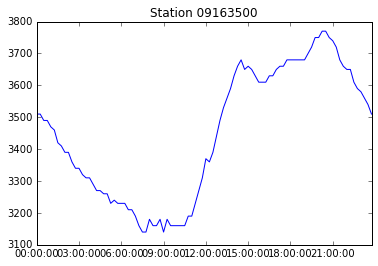

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(data['DateTime'], data['Discharge_cfs'])
plt.title('Station ' + data['Station'][0])

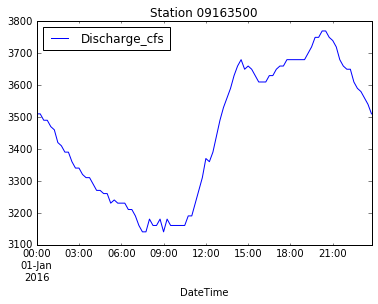

In [42]:
data.plot(x='DateTime', y='Discharge_cfs', title='Station ' + data['Station'][0])

We can use `pyplot` methods to customize the Pandas plot and save the figure:

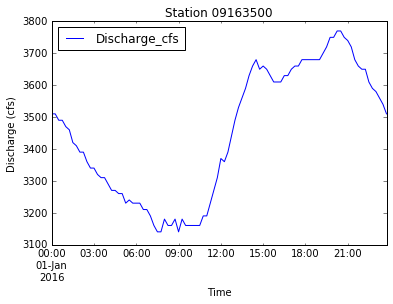

In [44]:
data.plot(x='DateTime', y='Discharge_cfs', title='Station ' + data['Station'][0])
plt.xlabel('Time')
plt.ylabel('Discharge (cfs)')
plt.show()
plt.savefig('data/discharge_' + data['Station'][0] + '.png')


## Putting it all together

Let's go back through the code we've written and put together just the commands we need to import data and make a plot of discharge.

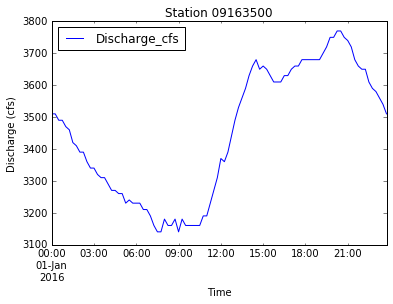

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('data/streamgage.csv')

new_column_names = ['Agency', 'Station', 'OldDateTime', 'Timezone', 'Discharge_cfs', 'Discharge_stat', 'Stage_ft', 'Stage_stat']
data.columns = new_column_names

data['DateTime'] = pd.to_datetime(data['OldDateTime'])

new_station_name = "0" + str(data['Station'].unique()[0])
data['Station'] = new_station_name

data.plot(x='DateTime', y='Discharge_cfs', title='Station ' + new_station_name)
plt.xlabel('Time')
plt.ylabel('Discharge (cfs)')
plt.savefig('data/discharge_' + new_station_name + '.png')
plt.show()